<a href="https://colab.research.google.com/github/ropas5/eye_diseases_classification_trabajo_DL/blob/main/nootbooks/01_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importamos los datos desde kaggle, creando la carpeta de data, con los datos comprmidos ( como se descarga por defecto de kaggle), y ha continuacion descomprimimos las carpetas con las imagenes

Versión de Colab

In [36]:
# !pip install kaggle

# from google.colab import files
# import os, zipfile
# from glob import glob

# # Subir kaggle.json
# files.upload()
# os.makedirs("/root/.kaggle", exist_ok=True)
# !mv kaggle.json /root/.kaggle/
# !chmod 600 /root/.kaggle/kaggle.json

# path = "data/raw"

# # Descargar
# os.makedirs(path, exist_ok=True)
# !kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification -p "{path}" --force

# with zipfile.ZipFile(path + "/eye-diseases-classification.zip", 'r') as zip_ref:
#     zip_ref.extractall(path)


Versión en local

In [37]:
import os
import zipfile

path = "../data/raw"

if not os.path.exists(path):
    os.makedirs(path)

#Descarga de datos desde kaggle
!kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification -p path

#Descomprimir zip
with zipfile.ZipFile(path +"/eye-diseases-classification.zip", 'r') as zip_ref:
    zip_ref.extractall(path)

"kaggle" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


## Preprocesamiento de los datos

In [38]:
import os
from PIL import Image
import numpy as np
import pandas as pd

path = path + "/dataset"
target_size = (128,128)

imgs = []
labels = []
folders = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

for folder in folders: 
    folder_path = os.path.join(path, folder) #Creamos la direccion de cada carpeta
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname) #obtenemos direccion de cada archivo
        try:
            with Image.open(fpath) as img:
                img = img.convert("RGB") # Lectura de image
                img = img.resize(target_size)
                arr = np.array(img)
            imgs.append(arr)
            labels.append(folder)
        except Exception as e:
            print("skip:", fpath, str(e))

X = np.stack(imgs)
y = np.array(labels)


## EDA

In [39]:
print("Tamaño del dataframe:", X.shape)
print("Tamaño de una imagene:", X[0].shape)

#Comprobamos que todas las imagenes tengan el mismo tamaño:
shapes = [img.shape for img in imgs]
unique_shapes = set(shapes)

print("Dimensiones encontradas:", unique_shapes)

Tamaño del dataframe: (4217, 128, 128, 3)
Tamaño de una imagene: (128, 128, 3)
Dimensiones encontradas: {(128, 128, 3)}


Visualizacion de imagenes

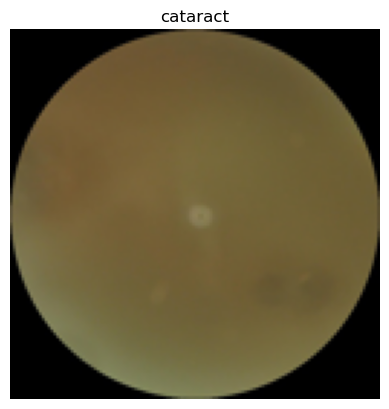

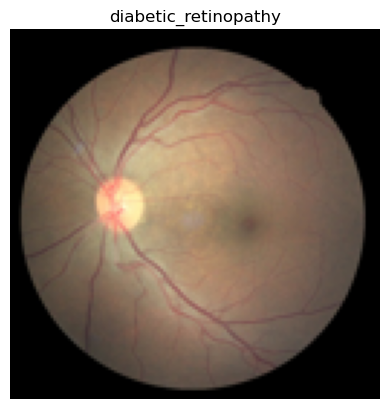

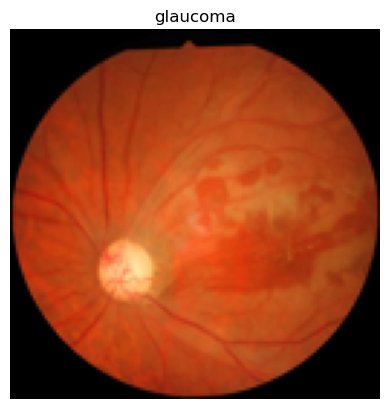

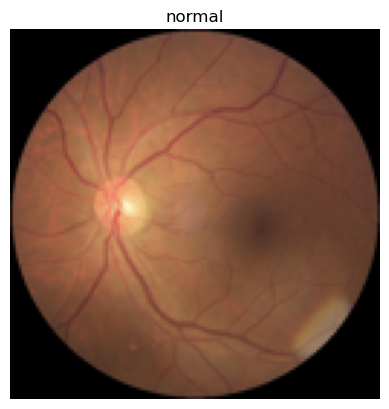

In [40]:
import matplotlib.pyplot as plt

classes = np.unique(y)

for label in classes:
    idx = np.where(y == label)[0][0]   # primer índice de esa clase
    plt.imshow(X[idx])
    plt.title(label)
    plt.axis("off")
    plt.show()

Distribución de las categorias

In [41]:
classes, counts = np.unique(y, return_counts=True)
percentages = counts / counts.sum() * 100

df_counts = pd.DataFrame({
    "clase": classes,
    "n_imagenes": counts,
    "porcentaje": percentages.round(2)
})

df_counts

,clase,n_imagenes,porcentaje
0,cataract,1038,24.61
1,diabetic_retinopathy,1098,26.04
2,glaucoma,1007,23.88
3,normal,1074,25.47


El conjunto de datos está formado por 4217 imágenes RGB de tamaño 512x512.
Todas las imágenes fueron redimensionadas al mismo tamaño, para poder aplicar facilmente la CNN.
La distribución de clases es la siguiente:
- normal 25.47%
- diabetic retinopathy 26.04%
- cataract 24.61%
- glaucoma 23.88%

Podemos ver como las clases estas bien distribuidas.

# Primeros Modelos
Modificamos la Y para tenerla como numero y no texto

In [42]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_int = le.fit_transform(y)

In [43]:
from tensorflow.keras.utils import to_categorical

y_cat = to_categorical(y_int, num_classes=4)

In [44]:
from sklearn.model_selection import train_test_split
random=42

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, train_size=0.7 ,random_state=random ,shuffle=True)

In [57]:
from sklearn.metrics import f1_score

results = pd.DataFrame(columns=[
    "model_name",
    "normalized",
    "epochs",
    "train_acc",
    "val_acc",
    "f1_test"])

def df_result(nombre, norm, model, hist):
  global results, X_test, y_test

  # Predecimos sobre el set de validación o test
  y_pred = model.predict(X_test)
  y_pred_classes = y_pred.argmax(axis=1) # convertimos a enteros

  y_test_classes = np.argmax(y_test, axis=1)

  # F1-score macro (igual peso a todas las clases)
  f1 = f1_score(y_test_classes, y_pred_classes, average="weighted")

  new_row = {
        "model_name": nombre,
        "normalized": norm,
        "epochs": len(hist.history["accuracy"]),
        "train_acc": hist.history["accuracy"][-1],
        "val_acc": hist.history["val_accuracy"][-1],
        "f1_test": f1
  }
  results = pd.concat([results, pd.DataFrame([new_row])], ignore_index=True)


In [56]:
#Modelo basico
try:
    import tensorflow
except ImportError:
    !pip install tensorflow
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, BatchNormalization, Dropout, MaxPooling2D
from keras import regularizers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


# create sequential model Basic network
model = Sequential()

# We add layers
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(128,128,3)))

model.add(Flatten())
model.add(Dense(4, activation='softmax'))

optimizer_adam = Adam()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.01)

model.compile(optimizer=optimizer_adam, loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train, y_train, validation_split=0.1, epochs=50, callbacks=[early_stopping])

Epoch 1/50


c:\Users\roger\miniconda3\envs\dl\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.5446 - loss: 292.0363 - val_accuracy: 0.7095 - val_loss: 8.9377
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.7096 - loss: 4.8108 - val_accuracy: 0.7297 - val_loss: 4.8607
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.7311 - loss: 3.7012 - val_accuracy: 0.7128 - val_loss: 5.2436
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.7782 - loss: 2.4296 - val_accuracy: 0.7399 - val_loss: 4.1674
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.8068 - loss: 1.9437 - val_accuracy: 0.7635 - val_loss: 4.4898
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.8252 - loss: 1.3980 - val_accuracy: 0.7128 - val_loss: 3.4079
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.8264 - loss: 1.5835 - val_accuracy: 0.7061 - val_loss: 3.7142
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.8493 - loss: 1.2416 - val_accuracy: 0.7466 - val_loss: 

In [58]:
df_result(nombre="Basic",norm= False, model= model, hist=hist)

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


C:\Users\roger\AppData\Local\Temp\ipykernel_30456\2321323915.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([new_row])], ignore_index=True)


In [59]:
# create sequential model Basic network
model = Sequential()

# We add layers
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(128,128,3)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(4, activation='softmax'))

optimizer_adam = Adam()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.01)

model.compile(optimizer=optimizer_adam, loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train, y_train, validation_split=0.1, epochs=50, callbacks=[early_stopping])

# Guardamos los resultados en un el df
df_result(nombre="Basic+BatchNormalization", norm=False, model=model, hist= hist)

Epoch 1/50


c:\Users\roger\miniconda3\envs\dl\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 221ms/step - accuracy: 0.6347 - loss: 23.2115 - val_accuracy: 0.6453 - val_loss: 11.9457
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 223ms/step - accuracy: 0.7522 - loss: 8.2100 - val_accuracy: 0.6351 - val_loss: 11.0462
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 18s 216ms/step - accuracy: 0.7928 - loss: 5.8258 - val_accuracy: 0.7770 - val_loss: 7.3345
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 17s 208ms/step - accuracy: 0.8392 - loss: 4.0218 - val_accuracy: 0.7736 - val_loss: 6.5235
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 17s 207ms/step - accuracy: 0.8719 - loss: 2.9593 - val_accuracy: 0.7838 - val_loss: 7.5618
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 17s 210ms/step - accuracy: 0.9017 - loss: 1.7168 - val_accuracy: 0.7939 - val_loss: 7.1050
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 17s 210ms/step - accuracy: 0.9220 - loss: 1.1550 - val_accuracy: 0.7872 - val_loss: 5.7455
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 17s 208ms/step - accuracy: 0.9345 - loss: 0.8877 - val_accuracy: 0.

Normalizamos los datos para obtener mejor resultado

In [53]:
X_train_norm = X_train.astype("float32")/255.0
X_test_norm = X_test.astype("float32")/255.0

In [60]:
# create sequential model Basic network
model = Sequential()

# We add layers
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(128,128,3)))
model.add(Flatten())
model.add(Dense(4, activation='softmax'))

optimizer_adam = Adam()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.01)

model.compile(optimizer=optimizer_adam, loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train, y_train, validation_split=0.1, epochs=50, callbacks=[early_stopping])

# Guardamos los resultados en un el df
df_result(nombre="Basic+Normlais", norm=True, model=model,hist= hist)

Epoch 1/50


c:\Users\roger\miniconda3\envs\dl\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.5277 - loss: 744.9832 - val_accuracy: 0.6993 - val_loss: 11.4673
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.7062 - loss: 4.9624 - val_accuracy: 0.6250 - val_loss: 5.7831
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.7239 - loss: 3.7906 - val_accuracy: 0.7196 - val_loss: 4.9469
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.7653 - loss: 2.3566 - val_accuracy: 0.6047 - val_loss: 6.6348
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.7725 - loss: 2.6092 - val_accuracy: 0.7095 - val_loss: 5.0042
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.8196 - loss: 1.3282 - val_accuracy: 0.7534 - val_loss: 5.0192
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.7910 - loss: 1.9873 - val_accuracy: 0.7095 - val_loss: 5.8950
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.8169 - loss: 1.4987 - val_accuracy: 0.7027 - val_loss:

In [61]:
results

,model_name,normalized,epochs,train_acc,val_acc,f1_test
0,Basic,False,39,0.952166,0.746622,0.709370
1,Basic+BatchNormalization,False,18,0.980414,0.766892,0.740527
2,Basic+Normlais,True,39,0.986064,0.736486,0.727672
